# 📩 **Email spam classification using NLP**

## 📚 **Importing all necessary libraries**

In [2]:
import os
import pandas as pd

import email 
from email import policy
from email.parser import BytesParser
import re

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

## 📂 **Creating the dataframe**

In [3]:
# Path to the dataset folder
dataset_folder = 'dataset'

# Initialize an empty list to store the data
data = []

# Iterate through each subdirectory (spam, hard_ham, easy_ham)
for folder_name in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder_name)
    
    # Determine the label based on the folder name
    if folder_name == 'spam':
        label = 'SPAM'
    else:
        label = 'HAM'
    
    # Iterate through each file in the subdirectory
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Read the content of the file
        with open(file_path, 'r', encoding='latin-1') as file:
            content = file.read()
        
        # Append the label and content to the data list
        data.append({'Label': label, 'Content': content})


# Create a DataFrame from the collected data
df_unshuffled = pd.DataFrame(data)
# Display the rows
print("Dataframe:\n\n",df_unshuffled)

df = df_unshuffled.sample(frac=1).reset_index(drop=True)

print("\nSchuffled Dataframe :\n\n",df)

Dataframe:

      Label                                            Content
0      HAM  From exmh-workers-admin@redhat.com  Thu Aug 22...
1      HAM  From Steve_Burt@cursor-system.com  Thu Aug 22 ...
2      HAM  From timc@2ubh.com  Thu Aug 22 13:52:59 2002\n...
3      HAM  From irregulars-admin@tb.tf  Thu Aug 22 14:23:...
4      HAM  From exmh-users-admin@redhat.com  Thu Aug 22 1...
...    ...                                                ...
4193  SPAM  From tba@insiq.us  Wed Dec  4 11:46:34 2002\nR...
4194  SPAM  Return-Path: <raye@yahoo.lv>\nReceived: from u...
4195  SPAM  From cweqx@dialix.oz.au  Tue Aug  6 11:03:54 2...
4196  SPAM  From ilug-admin@linux.ie  Wed Dec  4 11:52:36 ...
4197  SPAM  mv 00001.317e78fa8ee2f54cd4890fdc09ba8176 0000...

[4198 rows x 2 columns]

Schuffled Dataframe :

      Label                                            Content
0     SPAM  From spamassassin-sightings-admin@lists.source...
1     SPAM  From VWcmE8@sky.seed.net.tw  Tue Aug  6 12:52:...
2     S

## 🧹**Data cleaning** 

In [4]:
# Regex patterns to extract metadata
metadata_patterns = {
    'From': r"^From: (.*)$",
    'To': r"^To: (.*)$",
    'Subject': r"^Subject: (.*)$",
    'Date': r"^Date: (.*)$",
    
}

def parse_email(raw_email):
    # Parse email metadata
    metadata = {}
    for key, pattern in metadata_patterns.items():
        match = re.search(pattern, raw_email, re.MULTILINE)
        if match:
            metadata[key] = match.group(1)

    # Extract email body
    email_body_start = raw_email.find('\n\n') + 2
    body = raw_email[email_body_start:]

    return metadata, body


# Replace 'Content' with the appropriate column name if it's different

# Apply the parse_email function to each row in the DataFrame
parsed_data = df['Content'].apply(parse_email)

# Create a new DataFrame from the parsed email data
parsed_df = pd.DataFrame(parsed_data.tolist(), columns=['Metadata', 'Body'])
parsed_df.head()

,Metadata,Body
0,"{'From': '¤O±¶¬ì§Þ@mx.serv.net', 'To': 'nnn@mx...",¤£¦n·N«ä¥´ÅÍ±z¡I¦pªG¥»¼s§i«H¹ï±z²£¥Í§xÂZ¡A¦b¦¹...
1,"{'From': '8@ms34.url.com.tw', 'To': '1@dogma.s...",This is a multi-part message in MIME format.\n...
2,"{'From': '<noonelists8387@eudoramail.com>', 'T...","Dear Consumers, Increase your Business Sales! ..."
3,"{'From': '<lena_taylor@doneasy.com>', 'To': 'R...",.BIZ and .INFO Available Here\n\nDear sir/mada...
4,"{'From': '""Fergal Moran"" <fergal.moran@wasptec...",In a nutshell - Solaris is Suns own flavour of...


In [5]:
# Remove the date from the body
parsed_df['Body'] = parsed_df['Body'].apply(lambda x: re.sub(r"^Date: .*", "", x, flags=re.MULTILINE))

parsed_df.head()

,Metadata,Body
0,"{'From': '¤O±¶¬ì§Þ@mx.serv.net', 'To': 'nnn@mx...",¤£¦n·N«ä¥´ÅÍ±z¡I¦pªG¥»¼s§i«H¹ï±z²£¥Í§xÂZ¡A¦b¦¹...
1,"{'From': '8@ms34.url.com.tw', 'To': '1@dogma.s...",This is a multi-part message in MIME format.\n...
2,"{'From': '<noonelists8387@eudoramail.com>', 'T...","Dear Consumers, Increase your Business Sales! ..."
3,"{'From': '<lena_taylor@doneasy.com>', 'To': 'R...",.BIZ and .INFO Available Here\n\nDear sir/mada...
4,"{'From': '""Fergal Moran"" <fergal.moran@wasptec...",In a nutshell - Solaris is Suns own flavour of...


In [6]:

def remove_special_characters(text):
    # Define a regular expression pattern to match special characters
    pattern = r'[^a-zA-Z0-9\s]'  # Matches any character that is not a letter, digit, or whitespace

    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text


def parse_email_body(body):
    # Remove HTML tags
    body = re.sub(r'<[^>]+>', '', body)
    body = re.sub(r'nbsp', '',body)
    # Remove URLs
    body = re.sub(r'http\S+', '', body)
    # Remove special characters and escape sequences
    body = remove_special_characters(body)
    
    return body.strip()

# Apply the parse_email_body function to the 'Body' column of parsed_df
parsed_df['Body'] = parsed_df['Body'].apply(parse_email_body)
parsed_df.head()

,Metadata,Body
0,"{'From': '¤O±¶¬ì§Þ@mx.serv.net', 'To': 'nnn@mx...",nNzIpGsiHzxZAbPph\n\nOAFIzbtXH\n\ntHCXAMnHQAR4...
1,"{'From': '8@ms34.url.com.tw', 'To': '1@dogma.s...",This is a multipart message in MIME format\n\n...
2,"{'From': '<noonelists8387@eudoramail.com>', 'T...",Dear Consumers Increase your Business Sales \n...
3,"{'From': '<lena_taylor@doneasy.com>', 'To': 'R...",BIZ and INFO Available Here\n\nDear sirmadam\n...
4,"{'From': '""Fergal Moran"" <fergal.moran@wasptec...",In a nutshell Solaris is Suns own flavour of ...


In [7]:
# Define a function to extract the main body of the email

def extract_main_body(body):
    # Split the body by lines
    lines = body.split('\n')
    main_body_lines = []
    for line in lines:
        if not re.match(r'^[-]+\s*$', line) and not re.match(r'^------------------', line) and not re.match(r'^\s*Yahoo! Groups Sponsor', line) and not re.match(r'^Your use of Yahoo! Groups is subject to', line):
            main_body_lines.append(line)
    # Join the remaining lines to form the main body
    main_body = '\n'.join(main_body_lines)
    return main_body.strip()

# Apply the extract_main_body function to the 'Body' column of parsed_df
parsed_df['Body'] = parsed_df['Body'].apply(extract_main_body)


parsed_df.head()

,Metadata,Body
0,"{'From': '¤O±¶¬ì§Þ@mx.serv.net', 'To': 'nnn@mx...",nNzIpGsiHzxZAbPph\n\nOAFIzbtXH\n\ntHCXAMnHQAR4...
1,"{'From': '8@ms34.url.com.tw', 'To': '1@dogma.s...",This is a multipart message in MIME format\n\n...
2,"{'From': '<noonelists8387@eudoramail.com>', 'T...",Dear Consumers Increase your Business Sales \n...
3,"{'From': '<lena_taylor@doneasy.com>', 'To': 'R...",BIZ and INFO Available Here\n\nDear sirmadam\n...
4,"{'From': '""Fergal Moran"" <fergal.moran@wasptec...",In a nutshell Solaris is Suns own flavour of ...


In [8]:
# Concatenate the two DataFrames along the columns axis
merged_df = pd.concat([df, parsed_df], axis=1)
merged_df.head()

,Label,Content,Metadata,Body
0,SPAM,From spamassassin-sightings-admin@lists.source...,"{'From': '¤O±¶¬ì§Þ@mx.serv.net', 'To': 'nnn@mx...",nNzIpGsiHzxZAbPph\n\nOAFIzbtXH\n\ntHCXAMnHQAR4...
1,SPAM,From VWcmE8@sky.seed.net.tw Tue Aug 6 12:52:...,"{'From': '8@ms34.url.com.tw', 'To': '1@dogma.s...",This is a multipart message in MIME format\n\n...
2,SPAM,From noonelists8387@eudoramail.com Mon Jun 24...,"{'From': '<noonelists8387@eudoramail.com>', 'T...",Dear Consumers Increase your Business Sales \n...
3,SPAM,From lena_taylor@doneasy.com Mon Jun 24 17:03...,"{'From': '<lena_taylor@doneasy.com>', 'To': 'R...",BIZ and INFO Available Here\n\nDear sirmadam\n...
4,HAM,From ilug-admin@linux.ie Thu Aug 22 17:19:31 ...,"{'From': '""Fergal Moran"" <fergal.moran@wasptec...",In a nutshell Solaris is Suns own flavour of ...


In [9]:
# Drop the 'Metadata' and 'Content' columns from the DataFrame
merged_df = merged_df.drop(columns=['Metadata', 'Content'])
merged_df.head()

,Label,Body
0,SPAM,nNzIpGsiHzxZAbPph\n\nOAFIzbtXH\n\ntHCXAMnHQAR4...
1,SPAM,This is a multipart message in MIME format\n\n...
2,SPAM,Dear Consumers Increase your Business Sales \n...
3,SPAM,BIZ and INFO Available Here\n\nDear sirmadam\n...
4,HAM,In a nutshell Solaris is Suns own flavour of ...


In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4198 entries, 0 to 4197
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4198 non-null   object
 1   Body    4198 non-null   object
dtypes: object(2)
memory usage: 65.7+ KB


## 📊 **Data Visualization**

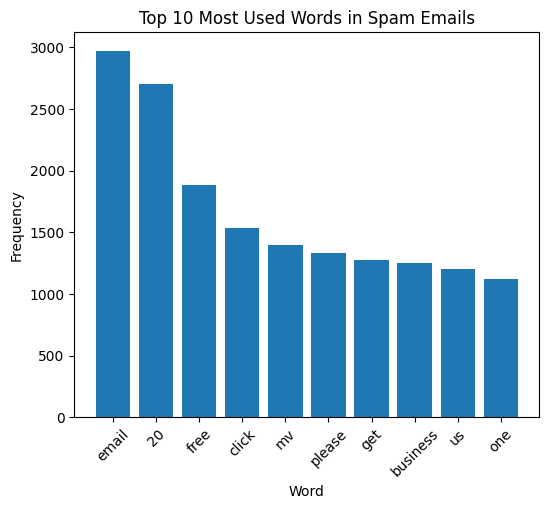

In [11]:
# Filter the DataFrame to include only spam emails
spam_df = merged_df[merged_df['Label'] == 'SPAM']

# Tokenize the text in the 'Body' column
tokens = []
for text in spam_df['Body']:
    tokens.extend(word_tokenize(text.lower()))  # Convert to lowercase



# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [token for token in tokens if token not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_tokens)

# Get most common words and their frequencies
top_words = word_counts.most_common(10)  

words, frequencies = zip(*top_words)

# Plot the most common words
plt.figure(figsize=(6, 5))
plt.bar(words, frequencies)
plt.title('Top 10 Most Used Words in Spam Emails')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Note :
- mv is short for Market Value

## 🔎 **Data Processing**

In [12]:
# Encoding the Label feature 
merged_df.loc[merged_df['Label'] == 'SPAM', 'Label'] = 0
merged_df.loc[merged_df['Label'] == 'HAM', 'Label'] = 1
merged_df.head()

,Label,Body
0,0,nNzIpGsiHzxZAbPph\n\nOAFIzbtXH\n\ntHCXAMnHQAR4...
1,0,This is a multipart message in MIME format\n\n...
2,0,Dear Consumers Increase your Business Sales \n...
3,0,BIZ and INFO Available Here\n\nDear sirmadam\n...
4,1,In a nutshell Solaris is Suns own flavour of ...


### Spliting the data into training and testing data

In [13]:
x = merged_df['Body']
y = merged_df['Label']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

### Transform the text data to feature vectors to be used as input

In [15]:
#Feature extraction
feature_extraction = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
# Fit the vectorizer on the training data and transform both training and testing data
x_train_features = feature_extraction.fit_transform(x_train)
x_test_features = feature_extraction.transform(x_test)

In [16]:
# convert y_train and y_test values into integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [17]:
print(x_train)

964     Home Mortgage Network\n      \n  \n  \n   \n  ...
239     I cant believe I actually read a laughoutloud ...
2387    Microsoft has announced that they plan to remo...
990     To unsubscribe simply reply to this email mess...
108     Hello I am your hot lil horny toy\n    I am th...
                              ...                        
3444    On Mon 07 Oct 2002 080124 0200 Roi Dayan  wrot...
466     Guido\n   \n   I dont know how big that pickle...
3092    Below is the result of your feedback form  It ...
3772    Damn this thing is slick  Someone seems to hav...
860     felicityklugenet changed\n\n           What   ...
Name: Body, Length: 3358, dtype: object


In [18]:
print(x_train_features)

  (0, 23008)	0.07741431305091737
  (0, 39644)	0.11212208942421131
  (0, 26175)	0.05848078979483245
  (0, 8226)	0.14306090001447294
  (0, 53265)	0.14306090001447294
  (0, 14046)	0.09516022074756132
  (0, 22618)	0.03464480854153994
  (0, 46613)	0.07213387994332979
  (0, 51527)	0.10673052655683872
  (0, 46443)	0.07682463062667172
  (0, 40156)	0.12346575598659647
  (0, 48201)	0.06661674304321738
  (0, 53338)	0.05433558962828464
  (0, 44876)	0.07964675650568594
  (0, 28403)	0.15029288464964408
  (0, 22107)	0.15029288464964408
  (0, 10329)	0.11212208942421131
  (0, 39964)	0.08405661526184285
  (0, 25749)	0.042262457255791454
  (0, 2161)	0.061649959023069925
  (0, 48650)	0.05670555318408435
  (0, 21697)	0.14306090001447294
  (0, 38692)	0.14306090001447294
  (0, 36685)	0.08087733190305618
  (0, 35052)	0.08847708768611753
  :	:
  (3357, 50155)	0.1393074083834873
  (3357, 15701)	0.11815699924103384
  (3357, 28221)	0.09832431349230054
  (3357, 26490)	0.09807551803852974
  (3357, 56936)	0.09375134

## 🤖 **Model training**

#### **LogisticRegression**

In [19]:
mailModel = LogisticRegression()

In [20]:
mailModel.fit(x_train_features, y_train)

LogisticRegression()

#### **Naive Bayes**

In [21]:
# store data as a matrix
cv= CountVectorizer()

x_train_count=cv.fit_transform(x_train.values)
x_test_count =cv.transform(x_test.values)

x_test_count.toarray()
x_train_count.toarray()

bModel=MultinomialNB()
#train
bModel.fit(x_train_count,y_train)

MultinomialNB()

## 📍 **Evaluationg the model's accuracy**

#### **LogisticRegression**

In [22]:
# Training Accuracy
prediction_training_data = mailModel.predict(x_train_features)
accuracy_training_data = accuracy_score(y_train, prediction_training_data)
print(accuracy_training_data)

0.9749851101846337


In [23]:
# Testing Accuracy
prediction_test_data = mailModel.predict(x_test_features)
accuracy_training_data = accuracy_score(y_test, prediction_test_data)
print(accuracy_training_data)

0.9738095238095238


#### **Naive Bayes**

In [24]:
# Training Accuracy
prediction_training_data = bModel.predict(x_train_count)
accuracy_training_data = accuracy_score(y_train, prediction_training_data)
print(accuracy_training_data)

0.9958308516974389


In [25]:
# Testing Accuracy
prediction_test_data = bModel.predict(x_test_count)
accuracy_test_data = accuracy_score(y_test, prediction_test_data)
print(accuracy_test_data)

0.9821428571428571


- Ensuring that the Naive Bayes model is not overfitting 

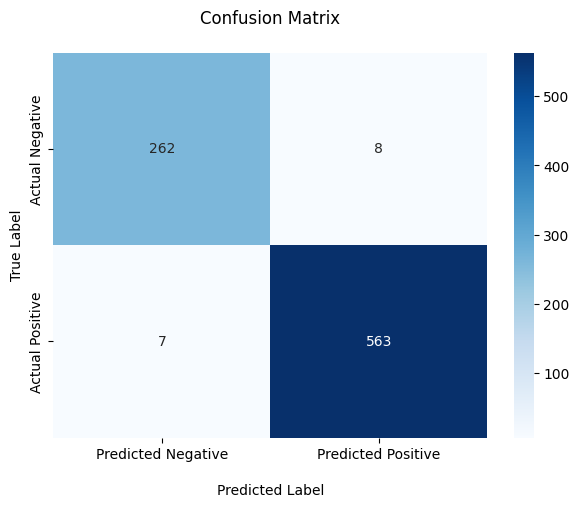

In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, prediction_test_data)

# Visualize
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('\nPredicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix\n')
plt.show()

## ✅ **Model Testing**

#### **LogisticRegression**

In [27]:
y_pred = mailModel.predict(x_test_features)

num_rows = 10

# Combine predicted and actual values for comparison
results = zip(y_pred[:num_rows], y_test[:num_rows])

# Print predicted and actual values
print("------ Values ------")
print("Predicted | Actual")
for pred, actual in results:
    print(f"{pred}         | {actual}")

------ Values ------
Predicted | Actual
1         | 1
1         | 1
1         | 1
1         | 1
1         | 1
1         | 1
1         | 1
1         | 1
1         | 1
1         | 1


In [32]:
# Input an email you wanna test !
#Testing with Ham mail
input_your_email = ["Hi,I just wanted to remind you about our meeting tomorrow at 10 AM. Please let me know if you have any questions."]
input_data_features = feature_extraction.transform(input_your_email)
prediction = mailModel.predict(input_data_features)
print("Result :")
if(prediction==1):
    print('Ham mail')
else:
    print('Spam mail')

Result :
Ham mail


In [28]:
# Input an email you wanna test !
#Testing with Spam mail
input_your_email = ["You won a free car !!  Click the link : http.freecars.com "]
input_data_features = feature_extraction.transform(input_your_email)
prediction = mailModel.predict(input_data_features)
print("Result :")
if(prediction==1):
    print('Ham mail')
else:
    print('Spam mail')

Result :
Spam mail


#### **Naive Bayes**

In [35]:
# preTest HAM
email_ham =["Hi don't forget the meeting tomorrow 9am !"]
email_ham_count = cv.transform(email_ham)
prediction = bModel.predict(email_ham_count)
print("Result :")
# Check the prediction result
if prediction == 1:
    print(" Ham mail")
else:
    print(" Spam mail")

Result :
 Ham mail


In [40]:
# preTest SPAM
email_spam =["Please Join us and get 20 000$ to start your buisness !"]
email_spam_count=cv.transform(email_spam)
prediction = bModel.predict(email_spam_count)
print("Result :")
# Check the prediction result
if prediction == 1:
    print("Ham mail")
else:
    print("Spam mail")

Result :
Spam mail
